## Chi square plot

In [1]:
import numpy as np
import bilby
from matplotlib import pyplot as plt

In [2]:
from tqdm import tqdm
from scipy.stats import chi2
from scipy.signal.windows import tukey

In [3]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import matplotlib.patches as patches

In [4]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['text.usetex'] = True

In [5]:
duration = 4
sampling_freq = 2048
time_array = np.arange(0, 4, 1/sampling_freq)
frequency_array = bilby.core.utils.create_frequency_series(sampling_freq, duration)
psd = 1* np.ones_like(frequency_array)
N = int(duration*sampling_freq)

In [6]:
def create_t_domain_noise(sampling_freq, duration, psd):
    f_noise, freqs = bilby.core.utils.create_white_noise(sampling_freq, duration)*psd**0.5
    return bilby.core.utils.infft(f_noise, sampling_freq)

In [7]:
noise = create_t_domain_noise(sampling_freq, duration, psd)

In [8]:
window_tukey_half = tukey(len(time_array), alpha=8/10)
window_rect_half = np.zeros(len(time_array))
window_rect_half[N//2-N//4:N//2+N//4] = np.ones(N//2)

In [9]:
window_tukey_quarter = tukey(len(time_array), alpha=8/20)
window_rect_quarter = np.zeros(len(time_array))
window_rect_quarter[N//2-3*N//8:N//2+3*N//8] = np.ones(3*N//4)

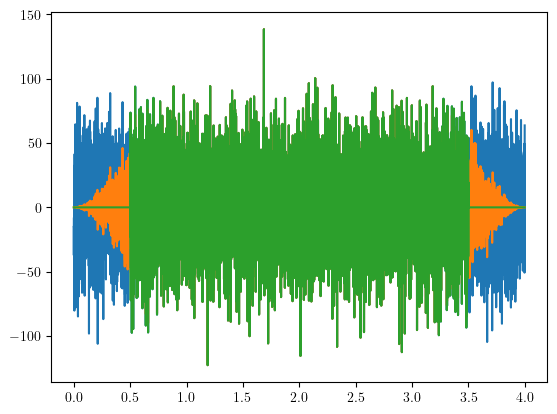

In [10]:
plt.plot(time_array, noise)
plt.plot(time_array, noise*window_tukey_quarter)
plt.plot(time_array, noise*window_rect_quarter)

In [11]:
noise_f, _ = bilby.core.utils.series.nfft(noise, sampling_freq)

/Users/sylvia.biscoveanu/mambaforge/envs/igwn-py310/lib/python3.10/site-packages/numpy/lib/histograms.py:839: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/sylvia.biscoveanu/mambaforge/envs/igwn-py310/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6794: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


(array([  3.,   2.,   9.,  18.,  20.,  52.,  59.,  77., 141., 185., 215.,
        288., 320., 363., 403., 395., 366., 297., 251., 190., 156., 118.,
         66.,  45.,  27.,  15.,  11.,   1.,   1.,   3.]),
 array([-2.37718347, -2.21731085, -2.05743822, -1.8975656 , -1.73769297,
        -1.57782035, -1.41794773, -1.2580751 , -1.09820248, -0.93832985,
        -0.77845723, -0.6185846 , -0.45871198, -0.29883935, -0.13896673,
         0.0209059 ,  0.18077852,  0.34065114,  0.50052377,  0.66039639,
         0.82026902,  0.98014164,  1.14001427,  1.29988689,  1.45975952,
         1.61963214,  1.77950477,  1.93937739,  2.09925002,  2.25912264,
         2.41899526]),
 <BarContainer object of 30 artists>)

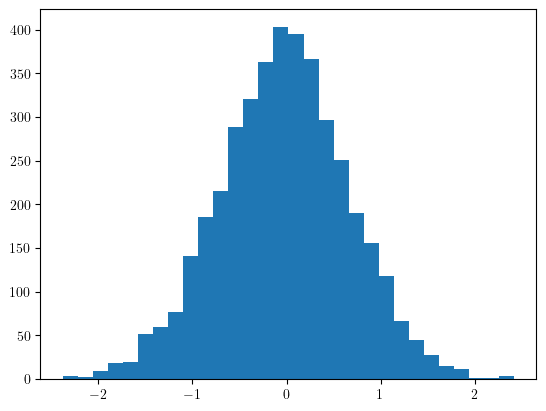

In [12]:
noise_f /= np.sqrt(duration * psd/2)
plt.hist(noise_f, bins=30)

In [13]:
np.std(noise_f)

0.9948600030032893

In [14]:
def chi_sq(freq_strain, duration, psd):
    return np.sum(4*(np.real(freq_strain)**2 + np.imag(freq_strain)**2)/(duration * psd))

In [15]:
chisqs_full = []
chisqs_rect = []
chisqs_tukey = []
for i in tqdm(range(10000)):
    noise = create_t_domain_noise(sampling_freq, duration, psd)
    noise_rect = noise*window_rect_half
    noise_tukey = noise*window_tukey_half
    noise_f, _ = bilby.core.utils.series.nfft(noise, sampling_freq)
    noise_f_rect, _ = bilby.core.utils.series.nfft(noise_rect, sampling_freq)
    noise_f_tukey, _ = bilby.core.utils.series.nfft(noise_tukey, sampling_freq)
    chisqs_full.append(chi_sq(noise_f, duration, psd))
    chisqs_rect.append(chi_sq(noise_f_rect, duration, psd))
    chisqs_tukey.append(chi_sq(noise_f_tukey, duration, psd))

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1989.28it/s]


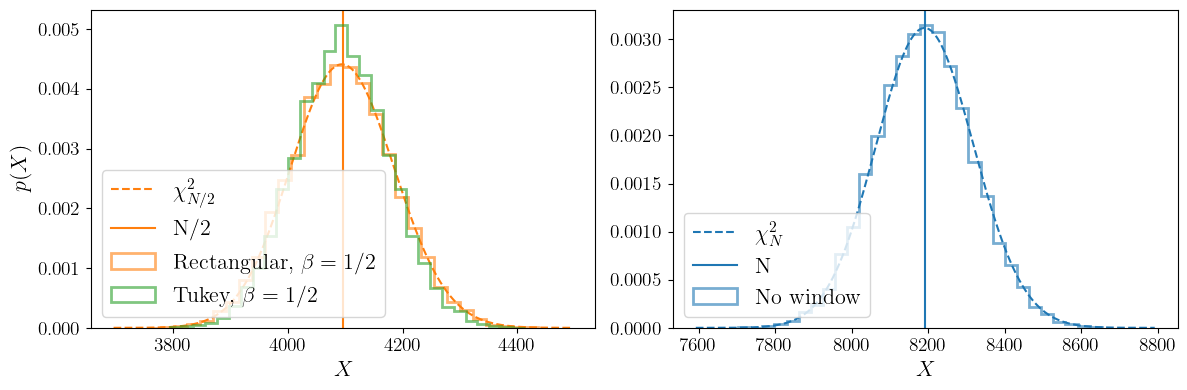

In [16]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
xs = np.linspace(N-600, N+600, 1000)
ax2.plot(xs, chi2.pdf(xs, df=N), color='#1f77b4', ls='--', label=r'$\chi^{2}_{N}$')
ax2.axvline(N, label='N', color='#1f77b4')
ax2.hist(chisqs_full, bins=30, density=True, histtype='step', lw=2, label='No window', alpha=0.6)
ax2.set_xlabel(r'$X$', fontsize=16)
ax2.tick_params(axis="both", labelsize=14)
ax2.legend(loc='lower left', fontsize=16)

xs_rect = np.linspace(N/2-400, N/2+400, 1000)
ax1.plot(xs_rect, chi2.pdf(xs_rect, df=N/2), color='#ff7f0e', label=r'$\chi^{2}_{N/2}$', ls='--')
ax1.axvline(N/2, color='#ff7f0e', label='N/2')
ax1.hist(chisqs_rect, bins=30, density=True, histtype='step', color='tab:orange', label=r'Rectangular, $\beta=1/2$', lw=2, alpha=0.6)
ax1.hist(chisqs_tukey, bins=30, density=True, histtype='step', color='tab:green', lw=2, label=r'Tukey, $\beta=1/2$', alpha=0.6)
ax1.set_ylabel(r'$p(X)$', fontsize=16)
ax1.set_xlabel(r'$X$', fontsize=16)
ax1.tick_params(axis="both", labelsize=14)
ax1.legend(loc='lower left', fontsize=16)
plt.tight_layout()
plt.savefig('window_noise_stats_demo.png', dpi=300)

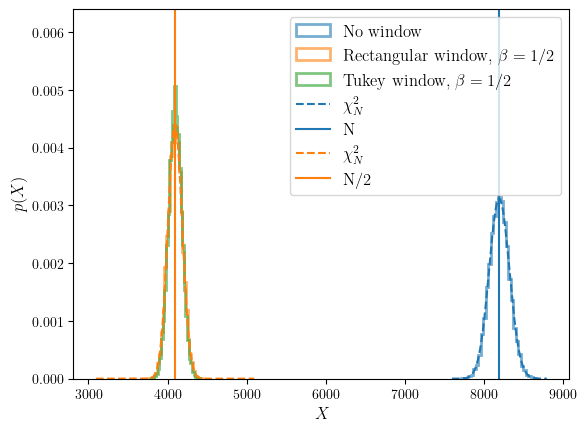

In [17]:
plt.hist(chisqs_full, bins=30, density=True, histtype='step', lw=2, label='No window', alpha=0.6)
plt.hist(chisqs_rect, bins=30, density=True, histtype='step', label=r'Rectangular window, $\beta=1/2$', lw=2, alpha=0.6)
plt.hist(chisqs_tukey, bins=30, density=True, histtype='step', lw=2, label=r'Tukey window, $\beta=1/2$', alpha=0.6)
plt.plot(xs, chi2.pdf(xs, df=N), color='#1f77b4', ls='--', label=r'$\chi^{2}_{N}$')
plt.axvline(N, label='N', color='#1f77b4')

xs_rect = np.linspace(N/2-1000, N/2+1000, 1000)
plt.plot(xs_rect, chi2.pdf(xs_rect, df=N/2), color='#ff7f0e', label=r'$\chi^{2}_{N}$', ls='--')
plt.axvline(N/2, color='#ff7f0e', label='N/2')
plt.ylim(0,0.0064)
plt.xlabel(r'$X$', fontsize=12)
plt.ylabel(r'$p(X)$', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
#plt.savefig('window_noise_stats_demo.png', dpi=300)

## Window plot

In [18]:
window_alpha1 = tukey(N, alpha=1)
window_alpha0 = tukey(N, alpha=0)
window_alpha0[0] = 0
window_alpha0[-1] = 0
window_alpha05 = tukey(N, alpha=0.5)

In [19]:
window_rect_half_padded = np.concatenate((window_rect_half, np.zeros(7*N)))
window_alpha1_padded = np.concatenate((window_alpha1, np.zeros(7*N)))
window_alpha05_padded = np.concatenate((window_alpha05, np.zeros(7*N)))

In [20]:
windowf_alpha1, new_freqs = bilby.core.utils.nfft(window_alpha1_padded, sampling_freq)
windowf_alpha0, new_freqs =  bilby.core.utils.nfft(window_rect_half_padded, sampling_freq)
windowf_alpha05, new_freqs = bilby.core.utils.nfft(window_alpha05_padded, sampling_freq)

/var/folders/kn/zqc4d69d5tv0pm29p7htw74m0000gn/T/ipykernel_27151/3460935259.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


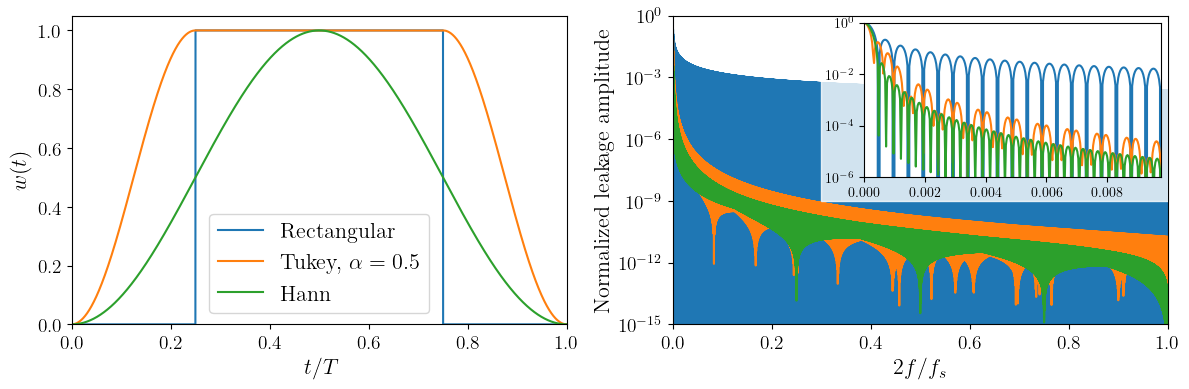

In [21]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax1.plot(time_array/duration, window_rect_half, label='Rectangular')
ax1.plot(time_array/duration, window_alpha05, label=r'Tukey, $\alpha=0.5$')
ax1.plot(time_array/duration, window_alpha1, label='Hann')
ax1.set_xlabel(r'$t/T$', fontsize=16)
ax1.set_ylabel(r'$w(t)$', fontsize=16)
ax1.tick_params(axis="both", labelsize=14)
ax1.legend(fontsize=16)
ax1.set_ylim(0,)
ax1.set_xlim(0,1)

# Right subplot: frequency-domain
ax2 = fig.add_subplot(122)
x_vals = new_freqs / (sampling_freq / 2)
ax2.plot(x_vals, abs(windowf_alpha0)/abs(windowf_alpha0[0]))
ax2.plot(x_vals, abs(windowf_alpha05)/abs(windowf_alpha05[0]))
ax2.plot(x_vals, abs(windowf_alpha1)/abs(windowf_alpha1[0]))
ax2.set_xlabel(r'$2f/f_{s}$', fontsize=16)
ax2.tick_params(axis="both", labelsize=14)
ax2.set_ylabel(r'Normalized leakage amplitude', fontsize=16)
ax2.set_yscale('log')
ax2.set_xlim(0,1)
ax2.set_ylim(1e-15, 1)

# Inset: zoom in on low-frequency region
axins = inset_axes(ax2, width="60%", height="50%", loc='upper right')
axins.plot(x_vals, abs(windowf_alpha0)/abs(windowf_alpha0[0]))
axins.plot(x_vals, abs(windowf_alpha05)/abs(windowf_alpha05[0]))
axins.plot(x_vals, abs(windowf_alpha1)/abs(windowf_alpha1[0]))
axins.set_xlim(0, 10 / (sampling_freq / 2))
axins.set_ylim(1e-6, 1)  # adjust as needed based on your data
axins.set_yscale('log')
axins.tick_params(labelsize=10)

#Add white background behind left y-axis ticks
ax2.add_patch(patches.Rectangle(
    (0.3, 1e-9), 1, 0.5,
    color='white', alpha=0.8, zorder=8)
)
    
# Optionally draw a box on the main plot to show zoom area
#mark_inset(ax2, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.tight_layout()
plt.savefig('windows.png', dpi=300)